<a href="https://colab.research.google.com/github/MatiasHolmemoMardal/FastMONAI/blob/main/heart_semantic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Binary semantic segmentation lung

In [8]:
%pip install fastmonai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached fastMONAI-0.3.0-py3-none-any.whl (28 kB)
  Using cached monai-1.1.0-202212191849-py3-none-any.whl (1.2 MB)
  Using cached fastai-2.7.10-py3-none-any.whl (240 kB)
  Using cached torchio-0.18.86-py2.py3-none-any.whl (172 kB)
  Using cached torch-1.13.1-cp39-cp39-manylinux1_x86_64.whl (887.4 MB)
  Using cached Deprecated-1.2.13-py2.py3-none-any.whl (9.6 kB)
  Using cached SimpleITK-2.2.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (52.7 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 57.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 78.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 106.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━

In [9]:
from fastMONAI.vision_all import *

from monai.apps import DecathlonDataset
from sklearn.model_selection import train_test_split

### Download external data


We use the MONAI function `DecathlonDataset` to download the data and generate items for training. 

set path

In [21]:
path = Path('../data')
path.mkdir(exist_ok=True)


Download the heart dataset

In [22]:
training_data = DecathlonDataset(root_dir=path, task="Task02_Heart", section="training", 
    download=True, cache_num=0, num_workers=3)

Task02_Heart.tar: 435MB [00:29, 15.4MB/s]                           

2023-04-20 10:53:38,757 - INFO - Downloaded: ../data/Task02_Heart.tar


2023-04-20 10:53:39,624 - INFO - Verified 'Task02_Heart.tar', md5: 06ee59366e1e5124267b774dbd654057.
2023-04-20 10:53:39,625 - INFO - Writing into directory: ../data.


Put dataset into a dataframe and print the shape

In [23]:
df = pd.DataFrame(training_data.data)
df.shape

(16, 2)

Split the labled data into training and test

In [24]:
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)
train_df.shape, test_df.shape

((14, 2), (2, 2))

### Examine the training data

Each class label will be counted for the masks (including the background) if you pass in the mask path and define the `dtype` to be `MedMask` in `MedDataset`

Create a MedDataset instance and preprocess the data, also summarizing the dataset information.

In [8]:
med_dataset = MedDataset(img_list=train_df.label.tolist(), dtype=MedMask, max_workers=12)

In [9]:
med_dataset.df.head()

,path,dim_0,dim_1,dim_2,voxel_0,voxel_1,voxel_2,orientation,voxel_count_0,voxel_count_1
0,../data/Task02_Heart/labelsTr/la_023.nii.gz,320,320,110,1.25,1.25,1.37,RAS+,11220796,43204
1,../data/Task02_Heart/labelsTr/la_004.nii.gz,320,320,110,1.25,1.25,1.37,RAS+,11205525,58475
2,../data/Task02_Heart/labelsTr/la_007.nii.gz,320,320,130,1.25,1.25,1.37,RAS+,13256556,55444
3,../data/Task02_Heart/labelsTr/la_022.nii.gz,320,320,110,1.25,1.25,1.37,RAS+,11230449,33551
4,../data/Task02_Heart/labelsTr/la_011.nii.gz,320,320,120,1.25,1.25,1.37,RAS+,12229545,58455


In [10]:
data_info_df = med_dataset.summary()

In [11]:
data_info_df.head()

,dim_0,dim_1,dim_2,voxel_0,voxel_1,voxel_2,orientation,example_path,total
3,320,320,110,1.25,1.25,1.37,RAS+,../data/Task02_Heart/labelsTr/la_004.nii.gz,4
4,320,320,120,1.25,1.25,1.37,RAS+,../data/Task02_Heart/labelsTr/la_005.nii.gz,4
1,320,320,100,1.25,1.25,1.37,RAS+,../data/Task02_Heart/labelsTr/la_009.nii.gz,2
0,320,320,90,1.25,1.25,1.37,RAS+,../data/Task02_Heart/labelsTr/la_016.nii.gz,1
2,320,320,109,1.25,1.25,1.37,RAS+,../data/Task02_Heart/labelsTr/la_029.nii.gz,1


In [12]:
resample, reorder = med_dataset.suggestion()
resample, reorder

([1.25, 1.25, 1.37], False)

In [13]:
bs=4

In [14]:
img_size = med_dataset.get_largest_img_size(resample=resample)
img_size

[320.0, 320.0, 130.0]

Define data augmentation and preprocessing transformations.

In [15]:
size = [160,160,128]

In [16]:
item_tfms = [ZNormalization(), PadOrCrop(size), RandomAffine(scales=0, degrees=5)]  # RandomMotion()

Create a MedDataBlock instance and dataloaders for the training and validation sets.

In [17]:
dblock = MedDataBlock(blocks=(ImageBlock(cls=MedImage), MedMaskBlock), 
                      splitter=RandomSplitter(valid_pct=0.1, seed=42), # By passing valid_pct=0.1, we tell it to get a random 10% of the training set for validation.
                      get_x=ColReader('image'),
                      get_y=ColReader('label'),
                      item_tfms=item_tfms,
                      reorder=reorder,
                      resample=resample) 

In [18]:
dls = dblock.dataloaders(train_df, bs=bs)

In [19]:
# training and validation
len(dls.train_ds.items), len(dls.valid_ds.items)

(13, 1)

Visualize a batch of data.

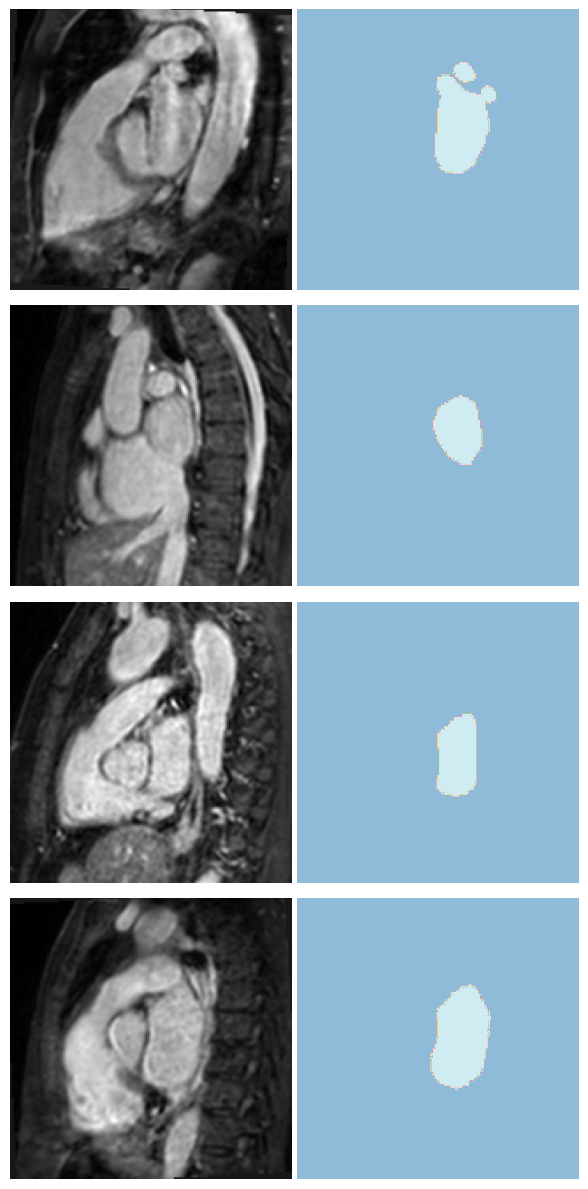

In [20]:
dls.show_batch(anatomical_plane=2) 

### Create and train a 3D model

Define a 3D U-Net model with specific architecture parameters.

In [21]:
from monai.networks.nets import UNet
from monai.losses import DiceLoss

In [22]:
model = UNet(spatial_dims=3, in_channels=1, out_channels=1, channels=(16, 32, 64, 128, 256),strides=(2, 2, 2, 2), num_res_units=2)
model = model.model

Define the DiceLoss as the loss function for training.

In [23]:
loss_func = CustomLoss(loss_func=DiceLoss(sigmoid=True))

Create a Learner object with the model, loss function, and optimizer (Ranger).

In [24]:
learn = Learner(dls, model, loss_func=loss_func, opt_func=ranger, metrics=binary_dice_score)

Perform learning rate finding to determine the optimal learning rate for training.

SuggestedLRs(valley=0.007585775572806597)

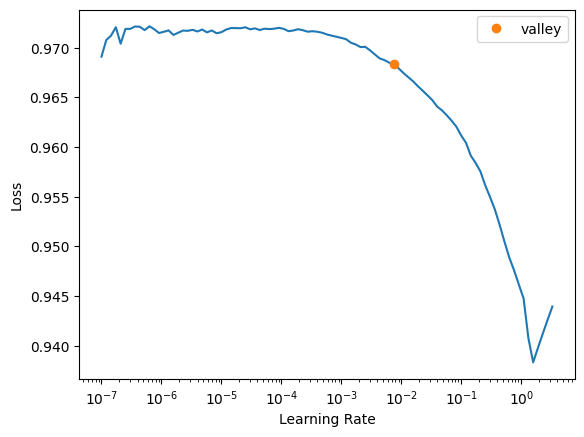

In [25]:
learn.lr_find()

Apply the learning rate to the learning pipeline

In [28]:
lr = 1e-2

In [ ]:
callbacks = EarlyStoppingCallback(monitor='valid_loss', patience=3)

Train the model with fit_flat_cos() with 200 epochs

In [31]:
learn.fit_flat_cos(200, lr)


epoch,train_loss,valid_loss,binary_dice_score,time
0,0.082997,0.189602,0.811246,00:05
1,0.089231,0.186534,0.814247,00:06
2,0.091584,0.208301,0.792171,00:06
3,0.094826,0.181560,0.819059,00:05
4,0.095981,0.206434,0.794810,00:05
5,0.104149,0.225123,0.775278,00:05
6,0.107793,0.257670,0.743734,00:05
7,0.113511,0.213324,0.787340,00:05
8,0.114399,0.207356,0.793419,00:05
9,0.116694,0.199419,0.800934,00:05


visual representation of the training progress of the deep learning model, plotting the loss over time

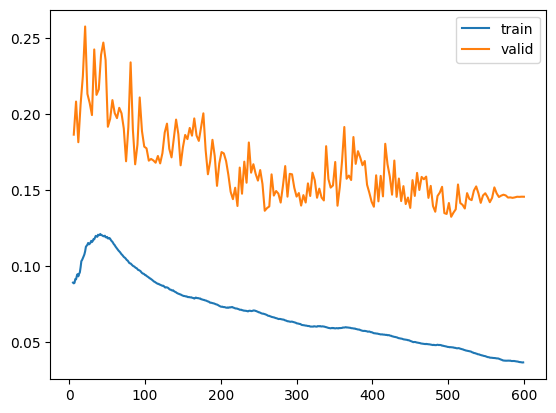

In [32]:
learn.recorder.plot_loss()

Save the model

In [33]:
learn.save('heart-model')

Path('models/heart-model.pth')

Show results with target and prediction

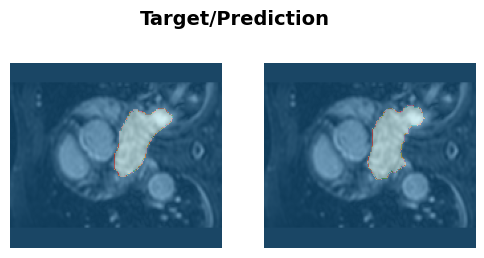

In [34]:
learn.show_results(anatomical_plane=1)

Export the model

In [39]:
if 'google.colab' in str(get_ipython()):
  temp_path = Path('/content/drive/MyDrive/DAT255/FastMONAI/models')
else:
  temp_path = Path(os.getcwd())
learn.path = temp_path

In [40]:
learn.export('fastmonai_model_heart.pkl')

### Test the model

In [ ]:
learn.load('heart-model')

In [43]:
test_dl = learn.dls.test_dl(test_df,with_labels=True)

Show batch with picture and mask

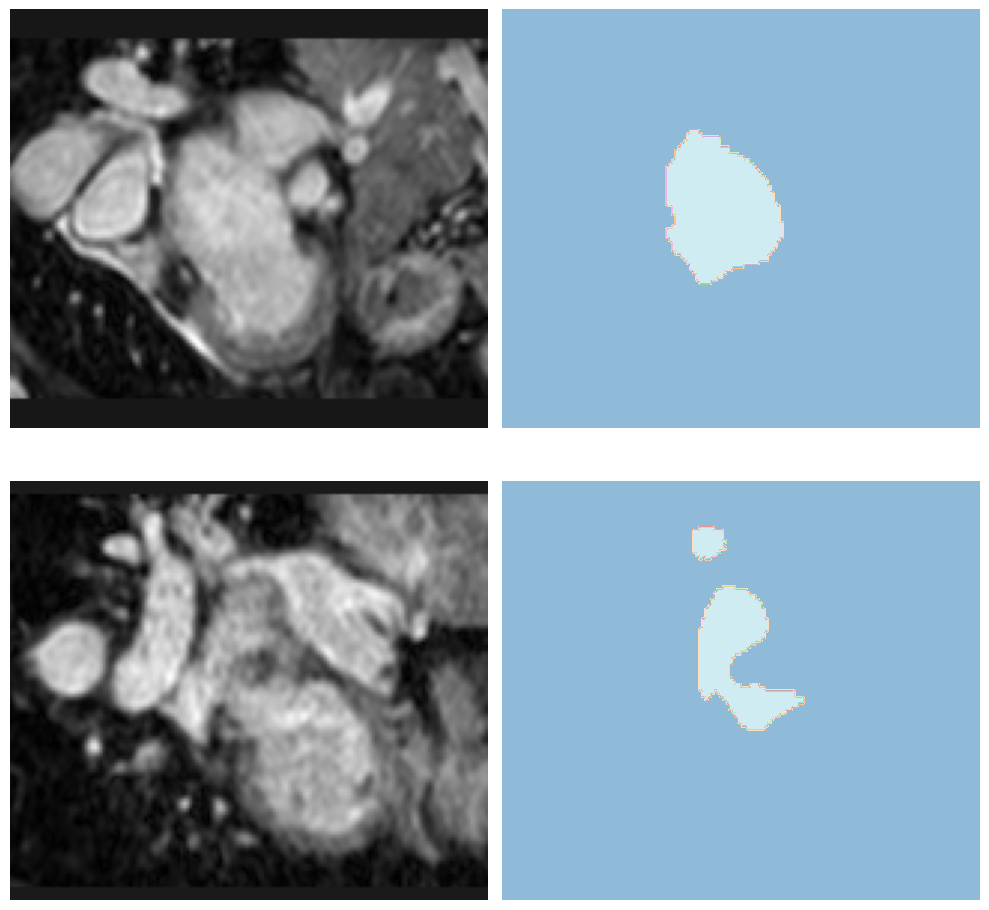

In [44]:
test_dl.show_batch(anatomical_plane=0, figsize=(10,10))

In [45]:
pred_acts, labels = learn.get_preds(dl=test_dl)
pred_acts.shape, labels.shape

(torch.Size([2, 1, 160, 160, 128]), torch.Size([2, 1, 160, 160, 128]))

Get the dice score

In [46]:
binary_dice_score(pred_acts, labels)

tensor(0.9110)

Show batch with target and prediction

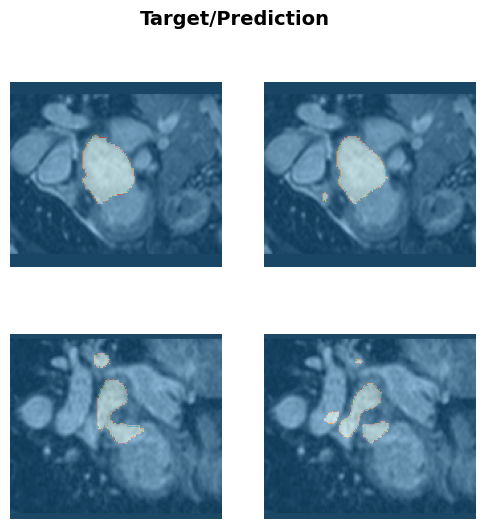

In [47]:
learn.show_results(anatomical_plane=0, dl=test_dl)

#Gradio

In [2]:
!pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 86.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.5/140.5 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.2/286.2 kB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.7/129.7 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 72.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.3/75.3 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 k

In [10]:
import fastai
from fastai.vision.all import *
import gradio as gr

# Load the exported model
path = Path(os.getcwd())
learn = load_learner('/content/drive/MyDrive/DAT255/FastMONAI/models/fastmonai_model_heart.pkl')


In [28]:
# Load the test dataset
test_data = DecathlonDataset(root_dir=path, task="Task02_Heart", section="validation")

# Define the predict function
def predict(dummy_input):
    # Select a random file from the test dataset and return its path
    idx = random.randint(0, len(test_data) - 1)
    return test_data[idx]["image"]

# Define the input and output interfaces
input_interface = gr.inputs.Dropdown(["Select Random Image"], label="Select Random Image")
output_interface = gr.outputs.Image(label="Output Image", type="numpy")

# Create the Gradio app
gr.Interface(fn=predict, inputs=input_interface, outputs=output_interface).launch()



Loading dataset: 100%|██████████| 4/4 [00:01<00:00,  2.01it/s]
/usr/local/lib/python3.9/dist-packages/gradio/inputs.py:217: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.9/dist-packages/gradio/outputs.py:43: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

In [26]:
input_interface = gr.inputs.File(label="Input Image")
output_interface = gr.outputs.Image(label="Output Image", type="numpy")

# Create the Gradio app
gr.Interface(fn=predict, inputs=input_interface, outputs=output_interface).launch()

/usr/local/lib/python3.9/dist-packages/gradio/inputs.py:347: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.9/dist-packages/gradio/deprecation.py:40: UserWarning: `keep_filename` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.9/dist-packages/gradio/outputs.py:43: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>